## Imports ##

In [1]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor
from sklearn.svm import SVR

import pandas as pd
import pickle
import numpy as np

#### Datasets

In [2]:
# drugs
drugs = pd.read_csv('./data/drugs.csv', index_col=1)
drugs.drop(['Unnamed: 0'], axis=1, inplace=True)

# cell lines
cell_lines = pd.read_csv('./data/gene_expression.csv', index_col=0)

# combinations
combinations = pd.read_csv('./data/combinations.csv', index_col=0)

In [3]:
# reduce cell lines to the 2128 most important genes

with open('./data/2128_genes.pkl', 'rb') as f:
    top_genes = pickle.load(f)

filtered_cell_lines = cell_lines[cell_lines.columns.intersection(top_genes)]

### Merge data

In [4]:
drugs

,Drug
Drug_ID,
Camptothecin,CC[C@@]1(C2=C(COC1=O)C(=O)N3CC4=CC5=CC=CC=C5N=...
Vinblastine,CC[C@@]1(CC2C[C@@](C3=C(CCN(C2)C1)C4=CC=CC=C4N...
Cisplatin,N.N.[Cl-].[Cl-].[Pt+2]
Cytarabine,C1=CN(C(=O)N=C1N)[C@H]2[C@H]([C@@H]([C@H](O2)C...
Docetaxel,CC1=C2[C@H](C(=O)[C@@]3([C@H](C[C@@H]4[C@]([C@...
...,...
LJI308,C1COCCN1C2=CC=C(C=C2)C3=C(C=NC=C3)C4=CC(=C(C(=...
GSK591,C1CC(C1)NC2=NC=CC(=C2)C(=O)NC[C@@H](CN3CCC4=CC...
VE821,CS(=O)(=O)C1=CC=C(C=C1)C2=CN=C(C(=N2)C(=O)NC3=...


In [5]:
# transform smiles to fingerprints
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import MACCSkeys

def smiles_to_fingerprint(smiles):
    mol = Chem.MolFromSmiles(smiles)
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=512)
    return fp

def smiles_to_maccs(smiles):
    mol = Chem.MolFromSmiles(smiles)
    fp = MACCSkeys.GenMACCSKeys(mol)
    return fp

drugs['Drug'] = drugs['Drug'].apply(smiles_to_maccs)
drugs

,Drug
Drug_ID,
Camptothecin,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
Vinblastine,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
Cisplatin,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ..."
Cytarabine,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
Docetaxel,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, ..."
...,...
LJI308,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
GSK591,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ..."
VE821,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [6]:
drugs = pd.concat([drugs.drop(['Drug'], axis=1), drugs['Drug'].apply(lambda x: pd.Series({f'fp{str(i)}': val for i, val in enumerate(x)}))], axis=1)
drugs

/tmp/ipykernel_8544/378802255.py:1: FutureWarning: Returning a DataFrame from Series.apply when the supplied function returns a Series is deprecated and will be removed in a future version.
  drugs = pd.concat([drugs.drop(['Drug'], axis=1), drugs['Drug'].apply(lambda x: pd.Series({f'fp{str(i)}': val for i, val in enumerate(x)}))], axis=1)


,fp0,fp1,fp2,fp3,fp4,fp5,fp6,fp7,fp8,fp9,...,fp157,fp158,fp159,fp160,fp161,fp162,fp163,fp164,fp165,fp166
Drug_ID,,,,,,,,,,,,,,,,,,,,,
Camptothecin,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,0
Vinblastine,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,0
Cisplatin,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,1
Cytarabine,0,0,0,0,0,0,0,0,0,0,...,1,1,1,0,1,1,1,1,1,0
Docetaxel,0,0,0,0,0,0,0,0,1,0,...,1,1,1,1,1,1,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
LJI308,0,0,0,0,0,0,0,0,0,0,...,1,1,1,0,1,1,1,1,1,0
GSK591,0,0,0,0,0,0,0,0,0,0,...,1,1,1,0,1,1,1,1,1,0
VE821,0,0,0,0,0,0,0,0,0,0,...,0,1,1,1,1,1,1,1,1,0


In [16]:
# merge cell lines and drugs considering the combinations
final_df = pd.merge(combinations, drugs, on='Drug_ID')
final_df = pd.merge(final_df, filtered_cell_lines, left_on='Cell Line_ID', right_index=True, how = 'inner')
final_df.index = final_df['Drug_ID'] + '_' + final_df['Cell Line_ID']
final_df

KeyboardInterrupt: 

### Dataset splitting ###

In [9]:
input = final_df.drop(['Drug_ID', 'Cell Line_ID'], axis=1)
output = final_df['Y']


In [10]:
x_train, x_test, y_train, y_test = train_test_split(input, output, test_size=0.3, random_state=42)

In [11]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((64892, 2257), (64892,), (27811, 2257), (27811,))

In [12]:
x_train

,Y,fp0,fp1,fp2,fp3,fp4,fp5,fp6,fp7,fp8,...,ATP6V1E2,ZNF345,ATXN7L3B,PRKDC,PBOV1,OR13A1,ZNF253,MRPL46,OR1D5,MYH4
SCH772984_NCI-H1650,6.055741,0,0,0,0,0,0,0,0,0,...,4.620764,4.349685,6.059630,6.196544,2.969417,3.440274,3.671900,8.290864,3.462764,2.598925
Obatoclax Mesylate_NCI-H1944,2.466761,0,0,0,0,0,0,0,0,0,...,4.612394,3.852190,6.275888,7.392892,2.842712,3.200384,3.091870,8.878751,3.419733,2.557954
CZC24832_SW1417,7.301850,0,0,0,0,0,0,0,0,0,...,3.616349,2.757413,5.190664,5.445159,3.046510,3.419467,3.528807,8.456403,3.623589,2.622045
Dactolisib_SAT,-0.841943,0,0,0,0,0,0,0,0,0,...,4.637689,2.859829,6.172101,7.168179,3.061090,3.442887,3.679835,8.601642,3.270608,2.601103
Docetaxel_NCI-H2347,0.216742,0,0,0,0,0,0,0,0,1,...,4.827587,3.319316,6.296938,5.994890,2.933983,3.550379,4.037000,8.407811,3.447486,2.603918
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Paclitaxel_SW1463,-2.596284,0,0,0,0,0,0,0,0,1,...,4.793499,4.738768,6.726044,5.808590,2.832737,3.678759,4.410979,8.231673,3.377068,3.009807
PCI-34051_SW13,3.562308,0,0,0,0,0,0,0,0,0,...,7.431876,5.307546,6.100985,7.412594,2.729974,3.424994,4.368461,8.379001,3.570834,2.689459
Sepantronium bromide_OVISE,-4.351749,0,0,0,0,0,0,0,0,0,...,4.974294,5.191628,5.651242,6.762516,2.920320,3.273082,4.012576,7.305948,3.768384,2.655434
MK-2206_HCC2218,3.377403,0,0,0,0,0,0,0,0,0,...,4.061743,3.632399,6.157377,6.432589,3.374558,3.612480,3.698259,8.743277,3.809671,2.523288


### logistic

In [13]:
lr = LinearRegression()
lr.fit(x_train, y_train)
y_pred = lr.predict(x_test)
print('Linear Regression')
print('MAE: ', mean_absolute_error(y_test, y_pred))
print('MSE: ', mean_squared_error(y_test, y_pred))
print('RMSE: ', np.sqrt(mean_squared_error(y_test, y_pred)))




Linear Regression
MAE:  6.132329350475318e-15
MSE:  5.987174315205389e-29
RMSE:  7.737683319447358e-15


In [14]:
print(y_pred[:10])
print(*y_test[:10])

[ 3.292333  1.502017 -2.550424 -4.308333  3.559687  2.719596  5.262041
  5.50276   0.127412  0.585525]
3.292333 1.502017 -2.550424 -4.308333 3.559687 2.719596 5.262041 5.50276 0.127412 0.585525


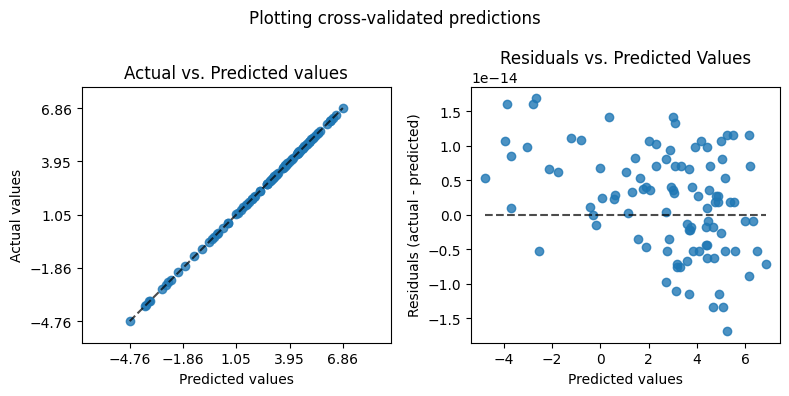

In [15]:
import matplotlib.pyplot as plt

from sklearn.metrics import PredictionErrorDisplay

fig, axs = plt.subplots(ncols=2, figsize=(8, 4))
PredictionErrorDisplay.from_predictions(
    y_test,
    y_pred=y_pred,
    kind="actual_vs_predicted",
    subsample=100,
    ax=axs[0],
    random_state=0,
)
axs[0].set_title("Actual vs. Predicted values")
PredictionErrorDisplay.from_predictions(
    y_test,
    y_pred=y_pred,
    kind="residual_vs_predicted",
    subsample=100,
    ax=axs[1],
    random_state=0,
)
axs[1].set_title("Residuals vs. Predicted Values")
fig.suptitle("Plotting cross-validated predictions")
plt.tight_layout()
plt.show()